In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.io as sio

from pathlib import Path
from matplotlib import pyplot as plt

import altair as alt
from altair.expr import datum

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
%load_ext watermark

In [3]:
%watermark --iversions

pandas    0.23.4
altair    2.1.0
scipy     1.1.0
ipywidgets7.2.1
matplotlib3.0.1
numpy     1.15.4



In [4]:
%matplotlib inline

## Set paths 

In [5]:
data_path = Path('../data')
path_to_results = data_path / "simulation_results"
khodayari_path = path_to_results / "Khodayari"
millard_path = path_to_results / "Millard"
kurata_path = path_to_results / "Kurata"
chassagnole_path = path_to_results / "Chassagnole"

In [6]:
# Load ID dataframes
khod_idf = pd.read_csv(data_path / "khodayari_id.csv")
millard_idf = pd.read_csv(data_path / "millard_id.csv")
kurata_idf = pd.read_csv(data_path / "kurata_id.csv")
chassagnole_idf = pd.read_csv(data_path / "chassagnole_id.csv")

In [7]:
from utils import (
    # zwf sensitivity
    get_kurata_zwf,
    get_khodayari_zwf,
    get_millard_zwf,    
    # pgi sensitivity
    get_kurata_pgi,
    get_khodayari_pgi,
    get_millard_pgi,
    # eno sensitivity
    get_kurata_eno,
    get_khodayari_eno,
    get_millard_eno,
    load_khodayari,
    load_kurata,
    load_millard,
    loadmat
)

In [8]:
# useful metrics to compare data
from utils import relative_error, normalized_error

# 1. Load the simulation data

In [9]:
khodayari_zwf = load_khodayari(
    sample_names="all",
    load_path=khodayari_path / "zwf_sensitivity",
    id_df=khod_idf,
    files=get_khodayari_zwf(),
)
khodayari_pgi = load_khodayari(
    sample_names="all",
    load_path=khodayari_path / "pgi_sensitivity",
    id_df=khod_idf,
    files=get_khodayari_pgi(),
)
khodayari_eno = load_khodayari(
    sample_names="all",
    load_path=khodayari_path / "eno_sensitivity",
    id_df=khod_idf,
    files=get_khodayari_eno(),
)

Loaded data file for sample dzwf which has flux matrix of (786, 9)
Loaded data file for sample WT which has flux matrix of (786, 98)
Loaded data file for sample zwf(15) which has flux matrix of (786, 6)
Loaded data file for sample dpgi which has flux matrix of (786, 5)
Loaded data file for sample pgi(0) which has flux matrix of (786, 15)
Loaded data file for sample pgi(20) which has flux matrix of (786, 2)
Loaded data file for sample pgi(50) which has flux matrix of (786, 2)
Loaded data file for sample pgi(100) which has flux matrix of (786, 2)
Loaded data file for sample WT which has flux matrix of (786, 98)
Loaded data file for sample eno(0) which has flux matrix of (786, 13)
Loaded data file for sample eno(50) which has flux matrix of (786, 2)
Loaded data file for sample eno(200) which has flux matrix of (786, 2)
Loaded data file for sample eno(500) which has flux matrix of (786, 2)
Loaded data file for sample WT which has flux matrix of (786, 98)


In [10]:
kurata_zwf = load_kurata(
    sample_names="all",
    load_path=kurata_path / "zwf_sensitivity",
    id_df=kurata_idf,
    files=get_kurata_zwf(),
)
kurata_pgi = load_kurata(
    sample_names="all",
    load_path=kurata_path / "pgi_sensitivity",
    id_df=kurata_idf,
    files=get_kurata_pgi(),
)
kurata_eno = load_kurata(
    sample_names="all",
    load_path=kurata_path / "eno_sensitivity",
    id_df=kurata_idf,
    files=get_kurata_eno(),
)

Loaded data file for sample dzwf which has flux matrix of (2101, 155)
Loaded data file for sample WT which has flux matrix of (2101, 155)
Loaded data file for sample zwf(15) which has flux matrix of (2101, 155)
Loaded data file for sample dpgi which has flux matrix of (2101, 155)
Loaded data file for sample pgi(0) which has flux matrix of (2101, 155)
Loaded data file for sample pgi(20) which has flux matrix of (2101, 155)
Loaded data file for sample pgi(50) which has flux matrix of (2101, 155)
Loaded data file for sample pgi(100) which has flux matrix of (2101, 155)
Loaded data file for sample WT which has flux matrix of (2101, 155)
Loaded data file for sample eno(0) which has flux matrix of (2101, 155)
Loaded data file for sample eno(50) which has flux matrix of (2101, 155)
Loaded data file for sample eno(200) which has flux matrix of (2101, 155)
Loaded data file for sample eno(500) which has flux matrix of (2101, 155)
Loaded data file for sample WT which has flux matrix of (2101, 155

In [11]:
millard_zwf = load_millard(
    sample_names="all",
    load_path=millard_path / "zwf_sensitivity",
    id_df=millard_idf,
    files=get_millard_zwf(),
)
millard_pgi = load_millard(
    sample_names="all",
    load_path=millard_path / "pgi_sensitivity",
    id_df=millard_idf,
    files=get_millard_pgi(),
)
millard_eno = load_millard(
    sample_names="all",
    load_path=millard_path / "eno_sensitivity",
    id_df=millard_idf,
    files=get_millard_eno(),
)

Loaded data file for sample dzwf which has flux matrix of (68,)
Loaded data file for sample WT which has flux matrix of (68,)
Loaded data file for sample zwf(15) which has flux matrix of (68,)
Loaded data file for sample dpgi which has flux matrix of (68,)
Loaded data file for sample pgi(0) which has flux matrix of (68,)
Loaded data file for sample pgi(20) which has flux matrix of (68,)
Loaded data file for sample pgi(50) which has flux matrix of (68,)
Loaded data file for sample pgi(100) which has flux matrix of (68,)
Loaded data file for sample WT which has flux matrix of (68,)
Loaded data file for sample eno(0) which has flux matrix of (68,)
Loaded data file for sample eno(50) which has flux matrix of (68,)
Loaded data file for sample eno(200) which has flux matrix of (68,)
Loaded data file for sample eno(500) which has flux matrix of (68,)
Loaded data file for sample WT which has flux matrix of (68,)


In [12]:
simulation_zwf = pd.concat(
    [khodayari_zwf, kurata_zwf, millard_zwf], sort=False
)
simulation_pgi = pd.concat(
    [khodayari_pgi, kurata_pgi, millard_pgi], sort=False
)
simulation_eno = pd.concat(
    [khodayari_eno, kurata_eno, millard_eno], sort=False
)

In [13]:
simulation_zwf.head()

,flux,ID,BiGG_ID,author,sample_id,normalized_flux
0,-0.020954,ACALD,ACALD,Khodayari,dzwf,-0.472740
1,-0.004096,ACALDtpp_ex,composed of ACALDtex and ACALDtpp,Khodayari,dzwf,-0.092400
2,-0.009307,ACKr,ACKr,Khodayari,dzwf,-0.209985
3,4.326233,ACONTa,ACONTa,Khodayari,dzwf,97.604637
4,4.441212,ACONTb,ACONTb,Khodayari,dzwf,100.198682


# 2. Load experimental data and mix it with simulation data

In [14]:
nicolas_df = pd.read_csv('../data/datasets/nicolas2007_tidy.csv')

In [15]:
df = nicolas_df

df = df.assign(author="Nicolas")
df = df.rename(
    {
        "Measurement_ID": "BiGG_ID",
        "Original_Value": "normalized_flux",
        "Value": "flux",
        "Original_ID": "ID",
        "Genotype": "sample_id",
    },
    axis=1,
)
df = df[df["Measurement_Type"] == "flux"]

df = df[["flux", "ID", "BiGG_ID", "author", "sample_id", "normalized_flux"]]
exp_results_zwf = df

In [16]:
exp_results_zwf.head()

,flux,ID,BiGG_ID,author,sample_id,normalized_flux
6,7.71000,pts,GLCptspp,Nicolas,dzwf,100.0
7,7.15000,pts,GLCptspp,Nicolas,WT,100.0
8,7.32000,pts,GLCptspp,Nicolas,zwf(15),100.0
9,7.59435,pgi,PGI,Nicolas,dzwf,98.5
10,5.60560,pgi,PGI,Nicolas,WT,78.4


In [17]:
all_results_zwf = pd.concat([simulation_zwf, exp_results_zwf], sort=False)

In [18]:
all_results_zwf.author.value_counts()

Khodayari    1371
Kurata        477
Millard       204
Nicolas        60
Name: author, dtype: int64

In [19]:
usui_df = pd.read_csv('../data/datasets/usui2012_tidy.csv')

In [20]:
df = usui_df

df = df.assign(author="Usui")
df = df.rename(
    {
        "Measurement_ID": "BiGG_ID",
        "Original_Value": "normalized_flux",
        "Value": "flux",
        "Original_ID": "ID",
        "Genotype": "sample_id",
    },
    axis=1,
)
df = df[df["Measurement_Type"] == "flux"]

df = df[["flux", "ID", "BiGG_ID", "author", "sample_id", "normalized_flux"]]
exp_results_pgi = df
exp_results_eno = df

In [21]:
all_results_pgi = pd.concat([simulation_pgi, exp_results_pgi], sort=False)

In [22]:
all_results_eno = pd.concat([simulation_eno, exp_results_eno], sort=False)

# 3. Subselect specific data and calculate error metrics

In [23]:
common_fluxes = set(khod_idf["BiGG ID"].unique()).intersection(
    set(millard_idf["BiGG ID"].unique()),
    set(kurata_idf["BiGG ID"].unique()),
   # set(chassagnole_idf["BiGG ID"].unique()), Chassagnole model does not contain TCA, that limits other models very significantly
)

In [24]:
common_fluxes = {x for x in common_fluxes if pd.notna(x)}
#common_fluxes

In [25]:
# common_fluxes = common_fluxes.intersection(set(exp_results.BiGG_ID.unique()))
# common_fluxes
common_fluxes = common_fluxes.intersection(
    set(exp_results_zwf.BiGG_ID.unique()),
    set(exp_results_pgi.BiGG_ID.unique()),
)

### ZWF experiment

In [26]:
# selected_reactions = [
#     "GLCptspp",
#     "PGI",
#     "G6PDH2r",
#     "GND",
#     "PYK",
#     "PPC",
#     "FUM",
#     "MDH",
#     "PDH",
#     #    "PTAr",
# ]

selected_reactions = [x for x in common_fluxes if pd.notna(x)]

selected_strains = ["dzwf", "zwf(15)", "WT"]
selected_authors = ["Khodayari", "Millard", "Kurata", "Nicolas"]
experimental_dataset = "Nicolas"

# select the right data and find median flux if there are several fluxes which are mapped to one BiGG ID
selected_data_zwf = (
    all_results_zwf[
        (all_results_zwf["BiGG_ID"].isin(selected_reactions))
        & (all_results_zwf["sample_id"].isin(selected_strains))
        & (all_results_zwf["author"].isin(selected_authors))
    ]
    .groupby(["BiGG_ID", "sample_id", "author"])
    .median()
    .reset_index()
)

# Calculate relative error
selected_data_zwf = (
    selected_data_zwf.groupby(["BiGG_ID", "sample_id"])
    .apply(relative_error, exp_name=experimental_dataset)
    .reset_index()
    .drop("level_2", axis=1)
)
# Calculate summary errors
normalized_errors_zwf = (
    selected_data_zwf.groupby(["sample_id"])
    .apply(normalized_error, exp_name=experimental_dataset)
    .unstack()
    .reset_index()
    .rename({0: "normalized_error"}, axis=1)
)

### PGI experiment

In [27]:
# selected_reactions = [
#     "GLCptspp",
#     "PGI",
#     "G6PDH2r",
#     "GND",
#     "PYK",
#     "PPC",
#     "FUM",
#     "MDH",
#     "PDH",
#     #    "PTAr",
# ]

selected_reactions = [x for x in common_fluxes if pd.notna(x)]

selected_strains = ["dpgi", "pgi(0)", "pgi(20)", "pgi(50)", "pgi(100)", "WT"]
selected_authors = ["Khodayari", "Millard", "Kurata", "Usui"]
experimental_dataset = "Usui"

# select the right data and find median flux if there are several fluxes which are mapped to one BiGG ID
selected_data_pgi = (
    all_results_pgi[
        (all_results_pgi["BiGG_ID"].isin(selected_reactions))
        & (all_results_pgi["sample_id"].isin(selected_strains))
        & (all_results_pgi["author"].isin(selected_authors))
    ]
    .groupby(["BiGG_ID", "sample_id", "author"])
    .median()
    .reset_index()
)

# For error calculation find only such values that are present in experimental dataset
flux_select = selected_data_pgi.groupby("BiGG_ID").apply(
    lambda x: any(x.author.str.contains(experimental_dataset))
).reset_index()
flux_ids = flux_select.loc[flux_select[0], "BiGG_ID"]
selected_data_pgi = selected_data_pgi[selected_data_pgi["BiGG_ID"].isin(flux_ids)]


# Calculate relative error
selected_data_pgi = (
    selected_data_pgi.groupby(["BiGG_ID", "sample_id"])
    .apply(relative_error, exp_name=experimental_dataset)
    .reset_index()
    .drop("level_2", axis=1)
)
# Calculate summary errors
normalized_errors_pgi = (
    selected_data_pgi.groupby(["sample_id"])
    .apply(normalized_error, exp_name=experimental_dataset)
    .unstack()
    .reset_index()
    .rename({0: "normalized_error"}, axis=1)
)

### ENO experiment

In [28]:
# selected_reactions = [
#     "GLCptspp",
#     "PGI",
#     "G6PDH2r",
#     "GND",
#     "PYK",
#     "PPC",
#     "FUM",
#     "MDH",
#     "PDH",
#     #    "PTAr",
# ]

selected_reactions = [x for x in common_fluxes if pd.notna(x)]

selected_strains = ["eno(50)", "eno(200)", "eno(500)", "WT"]
selected_authors = ["Khodayari", "Millard", "Kurata", "Usui"]
experimental_dataset = "Usui"

# select the right data and find median flux if there are several fluxes which are mapped to one BiGG ID
selected_data_eno = (
    all_results_eno[
        (all_results_eno["BiGG_ID"].isin(selected_reactions))
        & (all_results_eno["sample_id"].isin(selected_strains))
        & (all_results_eno["author"].isin(selected_authors))
    ]
    .groupby(["BiGG_ID", "sample_id", "author"])
    .median()
    .reset_index()
)

# For error calculation find only such values that are present in experimental dataset
flux_select = selected_data_eno.groupby(["BiGG_ID", "sample_id"]).apply(
    lambda x: any(x.author.str.contains(experimental_dataset))
).reset_index()
flux_ids = flux_select.loc[flux_select[0], "BiGG_ID"]
selected_data_eno = selected_data_eno[selected_data_eno["BiGG_ID"].isin(flux_ids)]

# Calculate relative error
selected_data_eno = (
    selected_data_eno.groupby(["BiGG_ID", "sample_id"])
    .apply(relative_error, exp_name=experimental_dataset)
    .reset_index()
    .drop("level_2", axis=1)
)
# Calculate summary errors
normalized_errors_eno = (
    selected_data_eno.groupby(["sample_id"])
    .apply(normalized_error, exp_name=experimental_dataset)
    .unstack()
    .reset_index()
    .rename({0: "normalized_error"}, axis=1)
)

In [29]:
normalized_errors = pd.concat([normalized_errors_zwf, normalized_errors_pgi, normalized_errors_zwf], axis = 0)
normalized_errors = normalized_errors.query("author == 'Khodayari' or author == 'Kurata' or author == 'Millard' ")

In [30]:
normalized_errors.head()

,author,sample_id,normalized_error
0,Khodayari,WT,0.684482
1,Khodayari,dzwf,0.809691
2,Khodayari,zwf(15),1.157426
3,Kurata,WT,0.624711
4,Kurata,dzwf,0.566981


# 4. Visualize

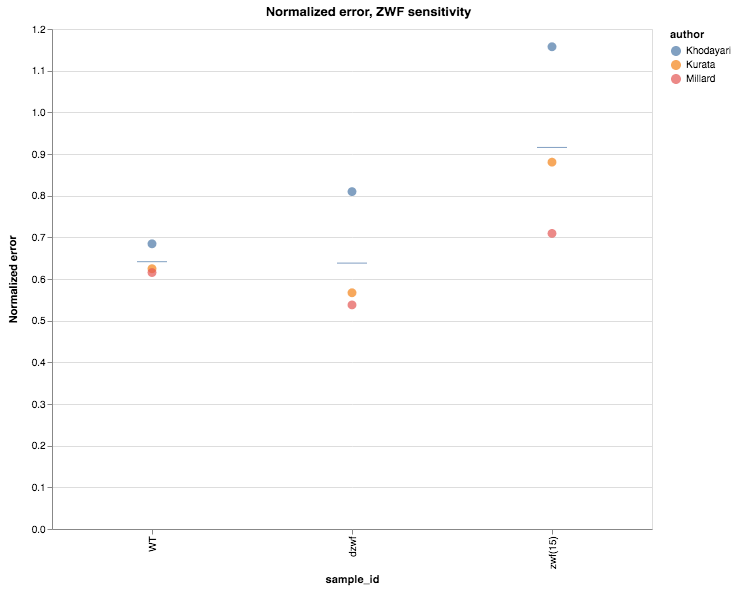

In [31]:
# put errors for each dataset as datapoints
errors = alt.Chart(
    normalized_errors_zwf.query("author != 'Nicolas'"),
    title = "Normalized error, ZWF sensitivity"
).mark_circle(size = 80).encode(
    y=alt.Y("normalized_error", title = "Normalized error"),   
    color=alt.Color("author", sort=["Khodayari", "Kurata", "Millard"]),
    tooltip = ["author", "sample_id", "normalized_error"],
    x=alt.X("sample_id", sort=["WT", "dzwf", "zwf(15)"]),
)

# add mean values
mean_error = alt.Chart(
    normalized_errors_zwf.query("author != 'Nicolas'").groupby("sample_id").mean().reset_index(),
).mark_tick(size = 30).encode(
    y=alt.Y("normalized_error"),
    x=alt.X("sample_id", sort=["Khodayari", "Kurata", "Millard"]),
    tooltip = ["normalized_error"]
)

(errors + mean_error).properties(width=600, height = 500)
# errors

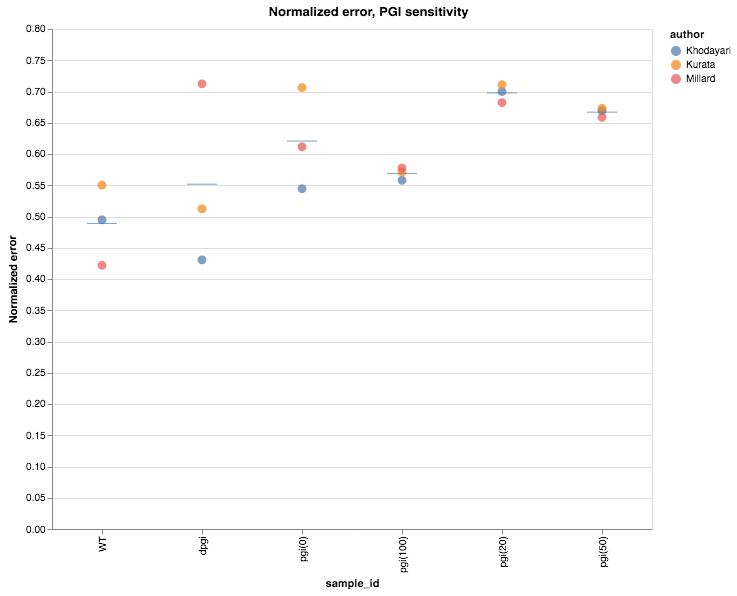

In [32]:
# put errors for each dataset as datapoints
errors = alt.Chart(
    normalized_errors_pgi.query("author != 'Usui'"),
    title = "Normalized error, PGI sensitivity"
).mark_circle(size = 80).encode(
    y=alt.Y("normalized_error", title = "Normalized error"),   
    color=alt.Color("author", sort=["Khodayari", "Kurata", "Millard"]),
    tooltip = ["author", "sample_id", "normalized_error"],
    x=alt.X("sample_id", sort=["WT", "dpgi", "pgi(0)", "pgi(20)", "pgi(50)", "pgi(100)"]),
)

# add mean values
mean_error = alt.Chart(
    normalized_errors_pgi.query("author != 'Usui'").groupby("sample_id").mean().reset_index(),
).mark_tick(size = 30).encode(
    y=alt.Y("normalized_error"),
    x=alt.X("sample_id", sort=["WT", "dpgi", "pgi(0)", "pgi(20)", "pgi(50)", "pgi(100)"]),
    tooltip = ["normalized_error"]
)

(errors + mean_error).properties(width=600, height = 500)

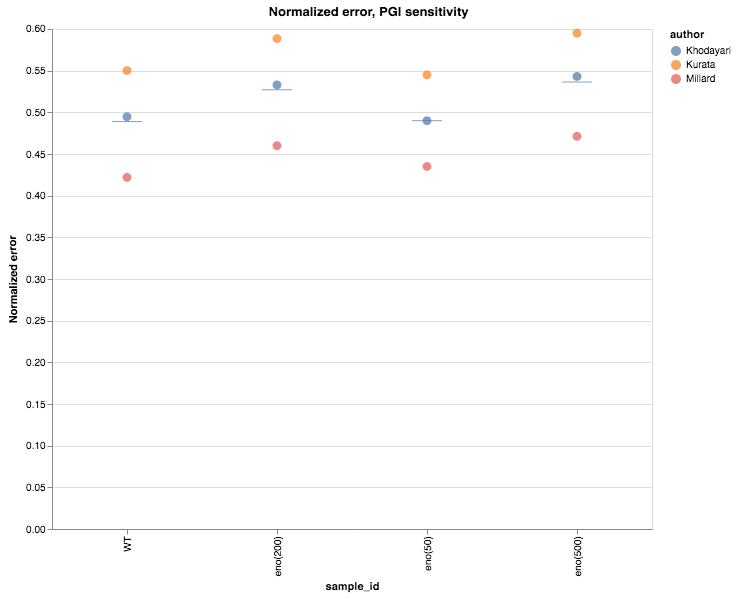

In [33]:
# put errors for each dataset as datapoints
errors = alt.Chart(
    normalized_errors_eno.query("author != 'Usui'"),
    title = "Normalized error, PGI sensitivity"
).mark_circle(size = 80).encode(
    y=alt.Y("normalized_error", title = "Normalized error"),   
    color=alt.Color("author", sort=["Khodayari", "Kurata", "Millard"]),
    tooltip = ["author", "sample_id", "normalized_error"],
    x=alt.X("sample_id", sort=["WT", "eno(50)", "eno(200)", "eno(500)"]),
)

# add mean values
mean_error = alt.Chart(
    normalized_errors_eno.query("author != 'Usui'").groupby("sample_id").mean().reset_index(),
).mark_tick(size = 30).encode(
    y=alt.Y("normalized_error"),
    x=alt.X("sample_id", sort=["WT", "eno(50)", "eno(200)", "eno(500)"]),
    tooltip = ["normalized_error"]
)

(errors + mean_error).properties(width=600, height = 500)

### Summary normalized error for the models

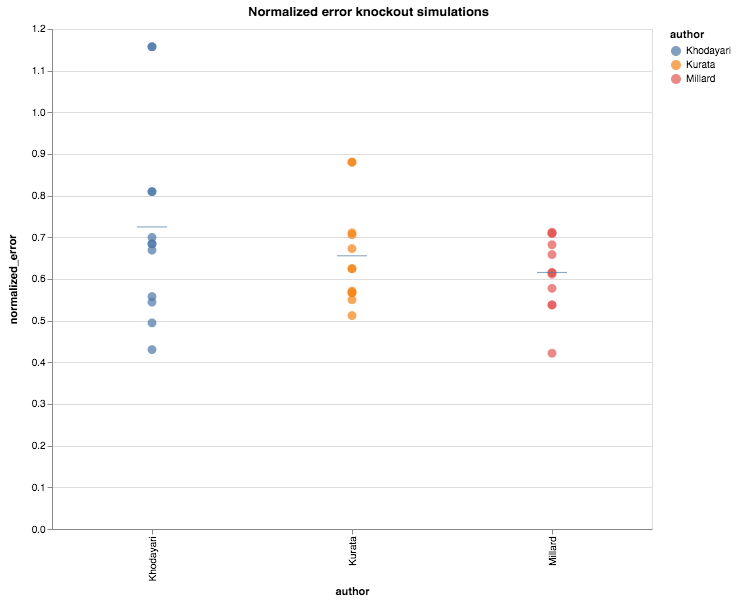

In [34]:
# put errors for each dataset as datapoints
errors = alt.Chart(
    normalized_errors,
    title = "Normalized error knockout simulations"
).mark_circle(size = 80).encode(
    y="normalized_error",    
    color=alt.Color("author", sort=["Khodayari", "Kurata", "Millard"]),
    tooltip = ["author", "sample_id", "normalized_error"],
    x=alt.X("author", sort=["Khodayari", "Kurata", "Millard"]),
)

# add mean values
mean_error = alt.Chart(
    normalized_errors.groupby("author").mean().reset_index(),
    # title = "Normalized error knockout simulations"
).mark_tick(size = 30).encode(
    y=alt.Y("normalized_error"),
    #color=alt.Color("author", sort=["Khodayari", "Kurata", "Millard", "COBRA"]),
    tooltip = ["normalized_error", "author"],
    x=alt.X("author", sort=["Khodayari", "Kurata", "Millard"]),
)

(errors + mean_error).properties(width=600, height = 500)

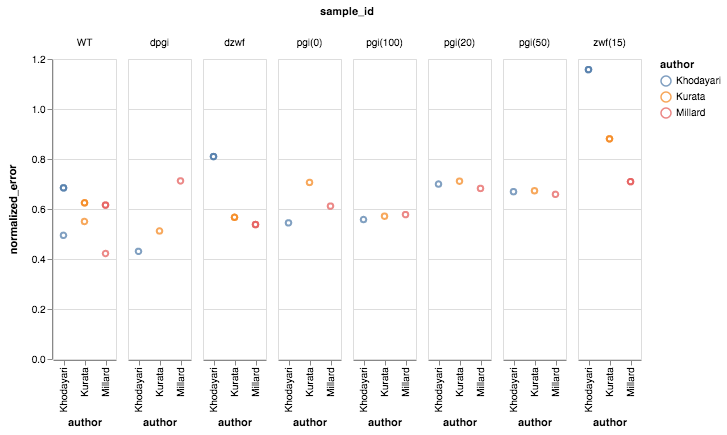

In [35]:
alt.Chart(normalized_errors).mark_point().encode(
    y = "normalized_error",
    x = alt.X("author:O", sort = [experimental_dataset]),
    column="sample_id:N",
    color=alt.Color("author", sort = [experimental_dataset]),
    tooltip=["author", "sample_id"],
)

In [109]:
# select the right data and find median flux if there are several fluxes which are mapped to one BiGG ID
plot_data = all_results[
    (all_results["BiGG_ID"].isin(selected_reactions))
    & (all_results["author"].isin(selected_authors))
].groupby(["BiGG_ID", "sample_id", "author"]).median().reset_index()

# make base plot that would be then modified to select only one strain
# altair.facet is not working with them so far
base = alt.Chart(plot_data, title="ZWF sensitivity fluxes").mark_bar().encode(
    y="normalized_flux:Q",
    x=alt.X("author:O", sort = ["Nicolas"]),
    column="BiGG_ID:N",
    color=alt.Color("author",sort=["Nicolas"]),
    tooltip=["author", "normalized_flux", "BiGG_ID", "sample_id"],
)


@interact_manual
def show_strain_comparison_plot(strain = selected_strains):
    return base.transform_filter(datum.sample_id == strain)

interactive(children=(Dropdown(description='strain', options=('dzwf', 'zwf(15)', 'WT'), value='dzwf'), Button(…

In [26]:
plot_data.head()

,BiGG_ID,sample_id,author,flux,normalized_flux
0,FUM,WT,Khodayari,88.489031,80.559575
1,FUM,WT,Kurata,1975.265390,52.506510
2,FUM,WT,Millard,0.277610,69.402491
3,FUM,WT,Nicolas,1.058200,14.800000
4,FUM,dzwf,Khodayari,5.882956,132.726029


In [107]:
rel_error = plot_data
rel_error = rel_error.groupby(["BiGG_ID", "sample_id"]).apply(lambda x: relative_error(x)).reset_index().drop("level_2", axis = 1)

In [108]:
# make base plot that would be then modified to select only one strain
# altair.facet is not working with them so far
base = alt.Chart(rel_error, title="ZWF sensitivity relative errors").mark_bar().encode(
    y="relative_error:Q",
    x=alt.X("author:O", sort = ["Nicolas"]),
    column="BiGG_ID:N",
    color=alt.Color("author",sort=["Nicolas"]),
    tooltip=["author", "relative_error", "BiGG_ID", "sample_id", "normalized_flux"],
)


@interact_manual
def show_strain_comparison_plot(strain = selected_strains):
    return base.transform_filter(datum.sample_id == strain)

interactive(children=(Dropdown(description='strain', options=('dzwf', 'zwf(15)', 'WT'), value='dzwf'), Button(…

In [33]:
sensitivity_data = pd.concat([selected_data_zwf, selected_data_pgi, selected_data_eno], sort=False)

In [37]:
path = data_path / "Processed"
path.mkdir(parents=True, exist_ok=True)
sensitivity_data.to_csv(path / "sensitivity.csv")